#0. Explore the images


In [17]:
import numpy as np
import os
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt



from skimage import data
from skimage.util import img_as_ubyte
from skimage import exposure
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

In [18]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import shutil
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    source = '/content/drive/MyDrive/AI6121/Assignment01 Histogram Equalization'
    destination = '/content'

    for sample_file in os.listdir(source):
        if sample_file.startswith('sample') and (sample_file.lower().endswith('jpg') or sample_file.lower().endswith('jpeg')):
            shutil.copyfile(os.path.join(source,sample_file), os.path.join(destination,sample_file)) 
    
    # cv2.imshow() will cause colab to crash so will need to use this instead
    from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [19]:
# Get all the image files in a list
sample_files = []
for sample_file in os.listdir():
    if sample_file.startswith('sample') and (sample_file.lower().endswith('jpg') or sample_file.lower().endswith('jpeg')):
        sample_files.append(sample_file)

sample_files.sort()

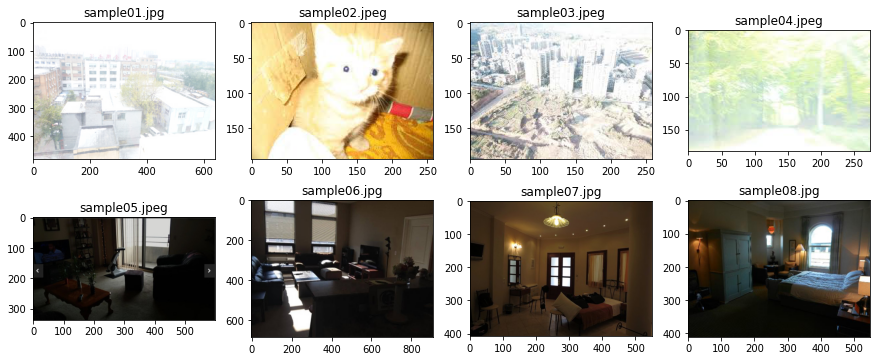

In [20]:
# Briefly check out all the images
# sample 1 to 4 are overexposed
# sample 5 to 8 are underexposed
plt.figure(figsize=(15,6))
for i in range(8):
    plt.subplot(2,4,i+1) 
    plt.imshow(np.array(Image.open(sample_files[i])))
    plt.title(sample_files[i])

plt.show()

# 1. Implementation of histogram equalisation algorithm

## 1.1 On RGB channel

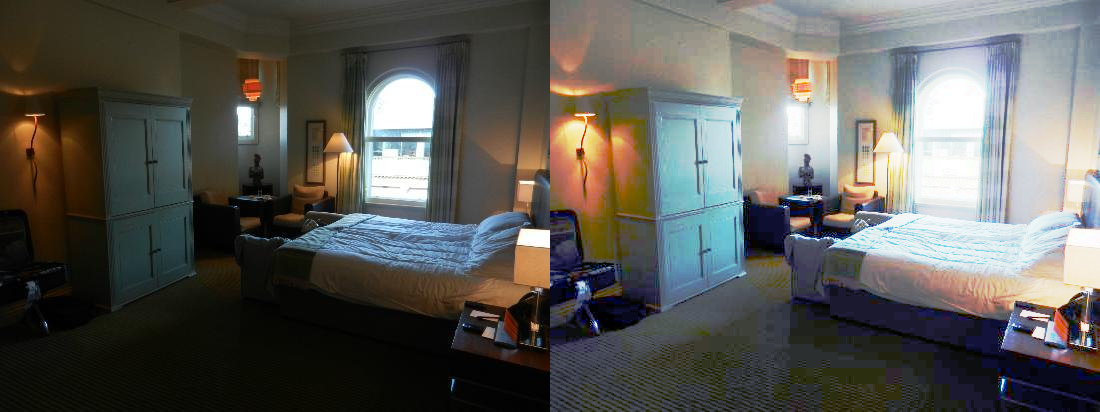

In [21]:
# For comparing a random image before and after histogram equalisation

rand_file = np.random.choice(sample_files)

rand_img = cv.imread(rand_file,1)
b,g,r = cv.split(rand_img)

def transform_pixel(channel):
    hist,bins = np.histogram(channel.flatten(),256,[0,256])
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf,0) # Hide the values that corresponds to pixel value that didnt exist in the image
    sk = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) # Scale the intensity value from the current range to 0~255
    rounded_sk = np.rint(np.ma.filled(sk,0)) 
    return rounded_sk

new_b = transform_pixel(b)[b]
new_g = transform_pixel(g)[g]
new_r = transform_pixel(r)[r]

if IN_COLAB:
    cv2_imshow(np.hstack((rand_img,cv.merge([new_b, new_g, new_r]))))
else:
    plt.figure(figsize = (15,15))
    plt.imshow(cv.cvtColor(np.hstack((rand_img,cv.merge([new_b, new_g, new_r]))).astype('uint8'), cv.COLOR_BGR2RGB))

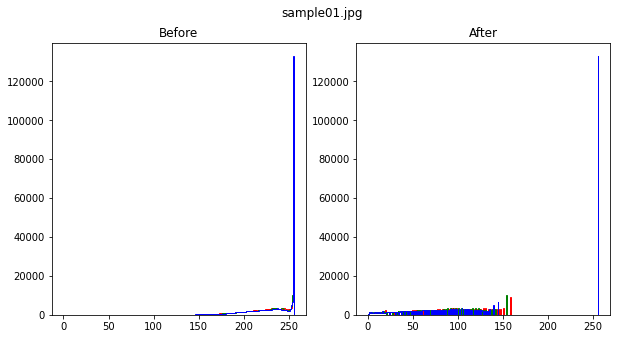

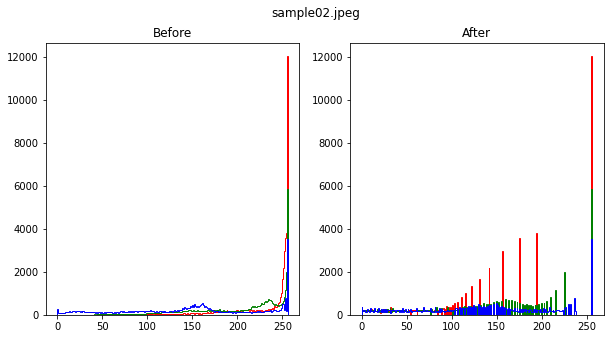

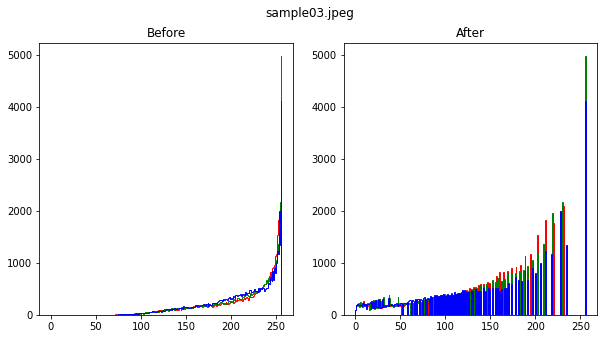

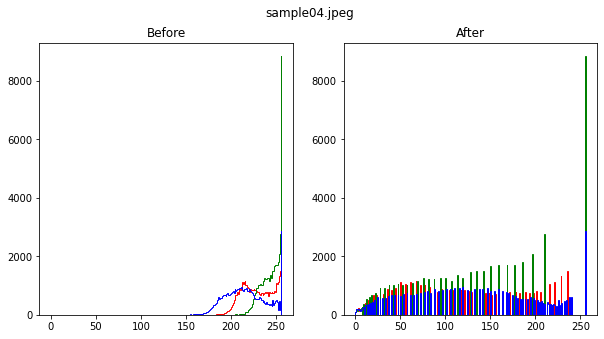

In [ ]:
def transform_pixel(channel):
    hist,bins = np.histogram(channel.flatten(),256,[0,256])
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf,0) # Hide the values that corresponds to pixel value that didnt exist in the image
    sk = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) # Scale the value from the current range to 0~255
    rounded_sk = np.rint(np.ma.filled(sk,0)) 
    return rounded_sk

# Save the histogram equalised images with a prefix 'he_'
for sample_file in sample_files:
    sample_img = cv.imread(sample_file)
    b,g,r = cv.split(sample_img)

    new_b = transform_pixel(b)[b]
    new_g = transform_pixel(g)[g]
    new_r = transform_pixel(r)[r]

    he_sample_img = cv.merge([new_b, new_g, new_r])
    cv.imwrite('he_'+sample_file, he_sample_img) # Save the new image to the folder

    # Plot their rgb histograms before and after the histogram equalisation
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
    ax1.hist(r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax1.hist(g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax1.hist(b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax1.set_title('Before')
    
    ax2.hist(new_r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax2.hist(new_g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax2.hist(new_b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax2.set_title('After')

    fig.suptitle(sample_file)
    plt.savefig(f'{sample_file.split(".")[0]}_before_after.png')
    plt.show()

In [ ]:
# Compare the images before and after the equalisation
for sample_file in sample_files:
    if IN_COLAB:
        print('#'*40,sample_file,'(before and after)','#'*40)
        cv2_imshow(np.hstack((cv.imread(sample_file),cv.imread('he_'+sample_file))))
    else:
        title = '#'*40+' '+sample_file+' (before and after) '+'#'*40
        plt.figure(figsize = (15,15))
        plt.title(title)
        plt.imshow(cv.cvtColor(np.hstack((cv.imread(sample_file),cv.imread('he_'+sample_file))).astype('uint8'), cv.COLOR_BGR2RGB))

    

## 1.2 On grayscale image

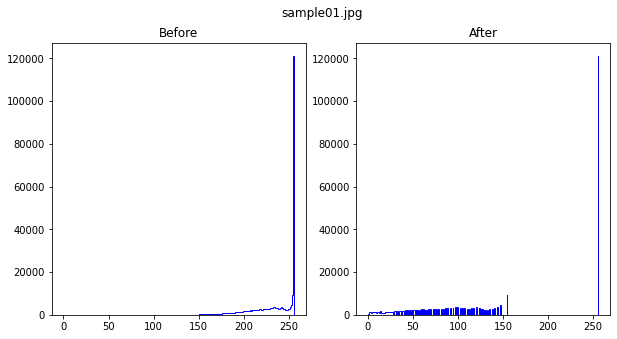

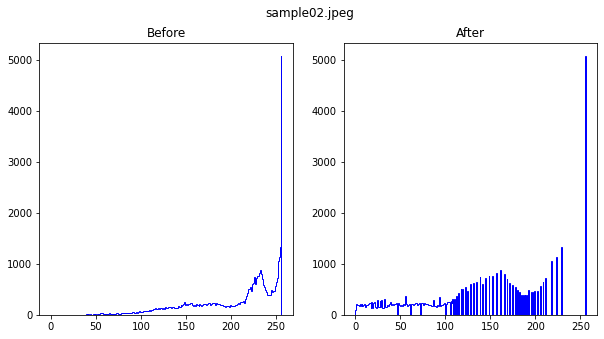

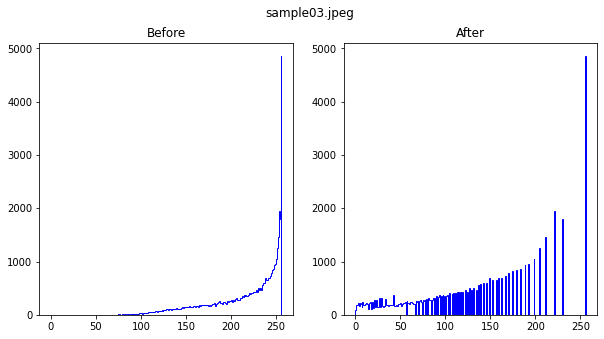

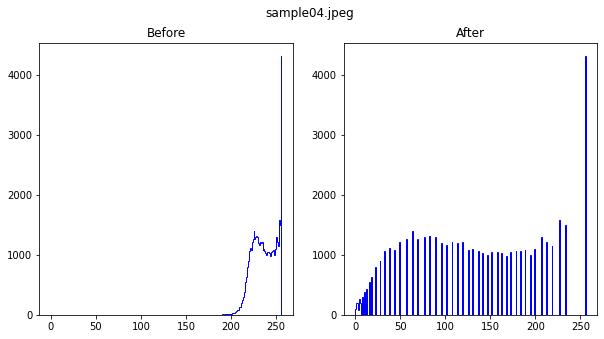

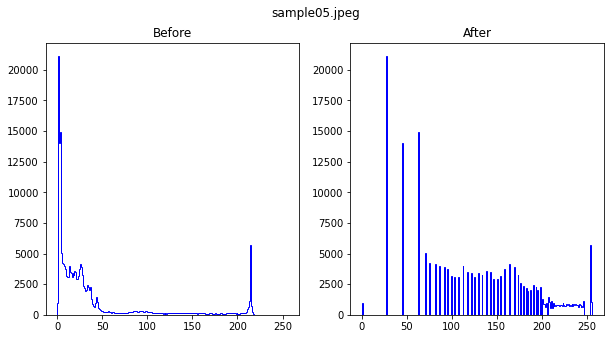

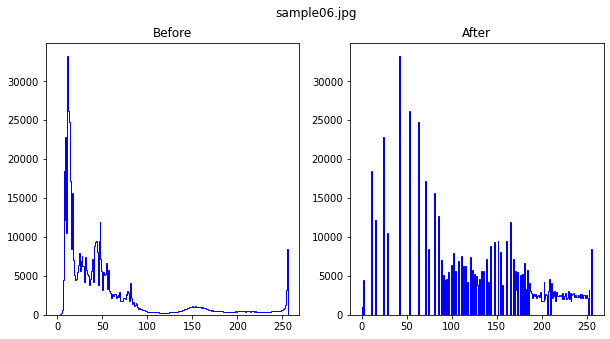

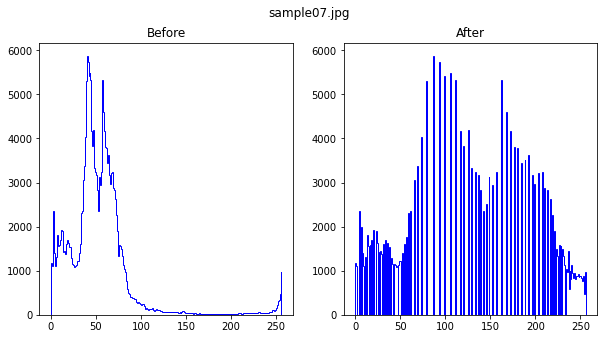

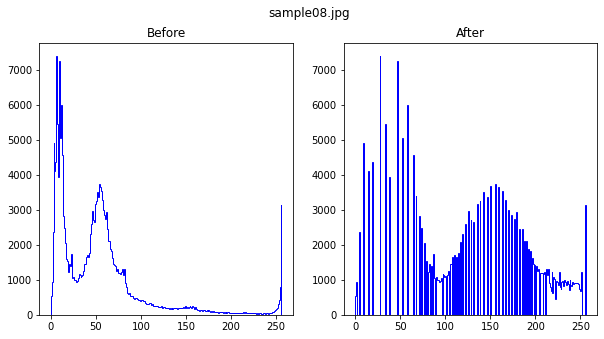

In [ ]:
# For grayscale images
# Save the histogram equalised images with a prefix 'he_gray_'
for sample_file in sample_files:
    sample_img = cv.imread(sample_file,0)

    he_gray_sample_img = transform_pixel(sample_img)[sample_img]

    cv.imwrite('he_gray_'+sample_file, he_gray_sample_img) # Save the new image to the folder

    # Plot their rgb histograms before and after the histogram equalisation
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
    ax1.hist(sample_img.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax1.set_title('Before')
    
    ax2.hist(he_gray_sample_img.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax2.set_title('After')

    fig.suptitle(sample_file)
    plt.savefig(f'{sample_file.split(".")[0]}_gray_before_after.png')
    plt.show()



######################################## sample01.jpg (before and after) ########################################


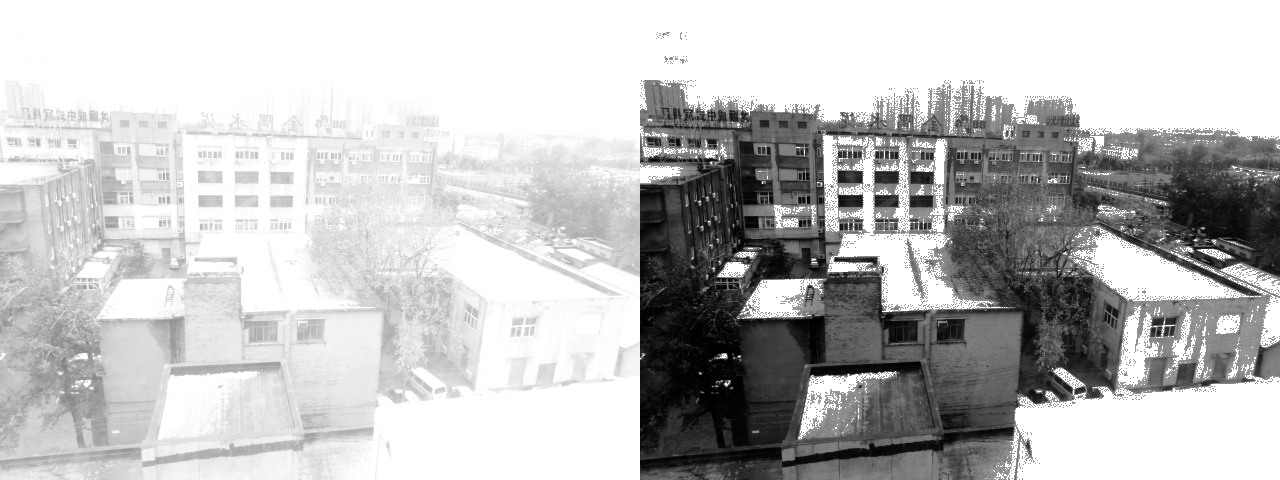

######################################## sample02.jpeg (before and after) ########################################


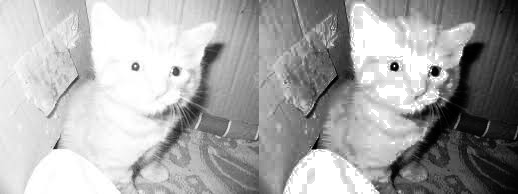

######################################## sample03.jpeg (before and after) ########################################


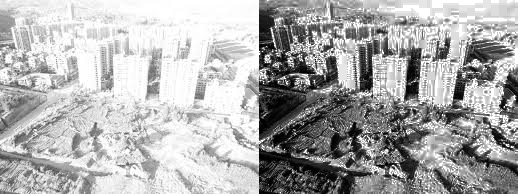

######################################## sample04.jpeg (before and after) ########################################


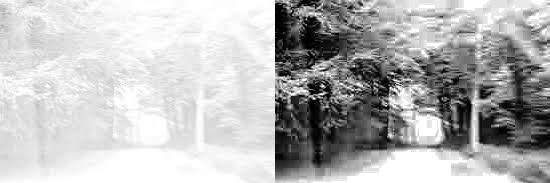

######################################## sample05.jpeg (before and after) ########################################


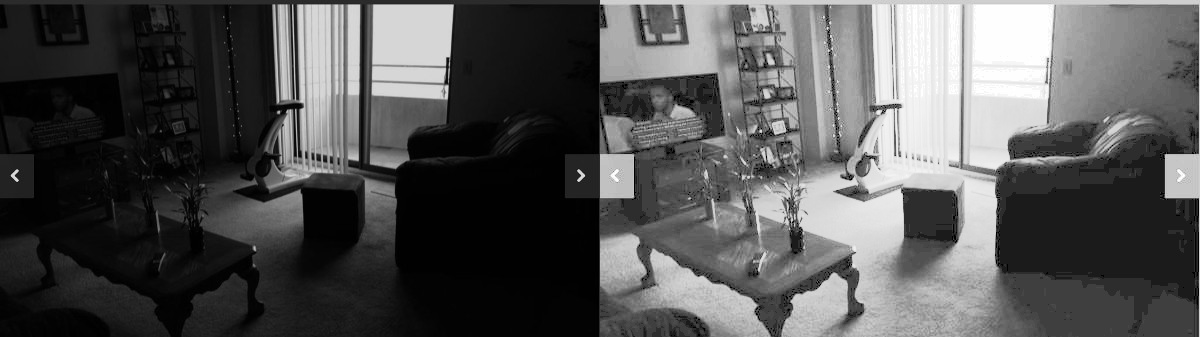

######################################## sample06.jpg (before and after) ########################################


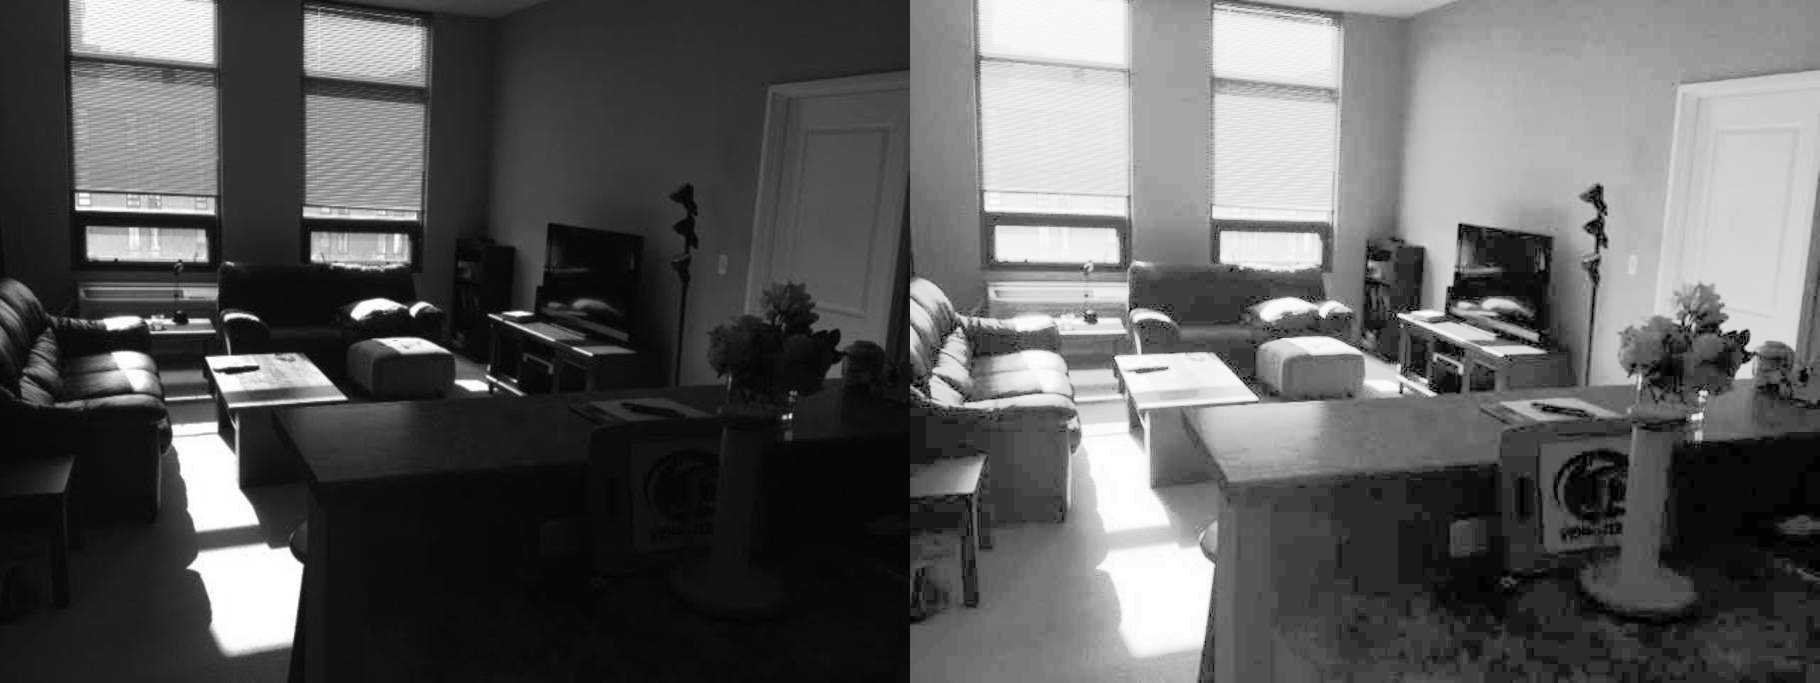

######################################## sample07.jpg (before and after) ########################################


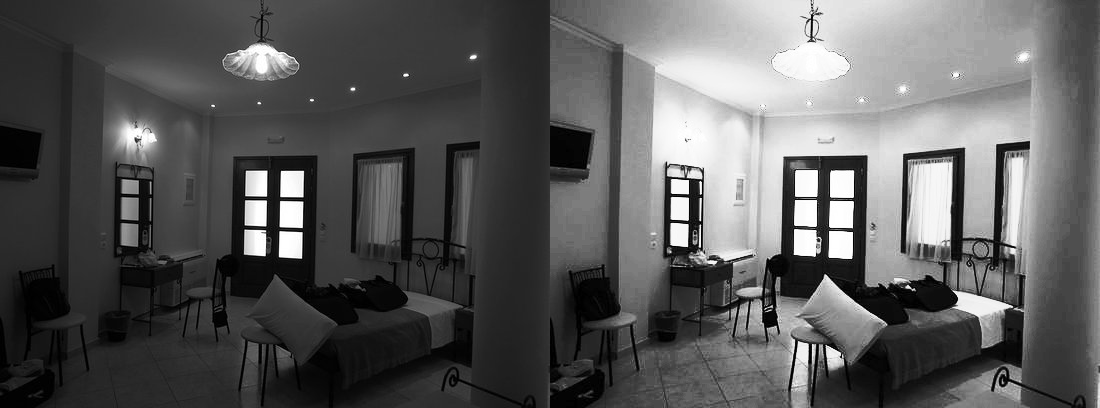

######################################## sample08.jpg (before and after) ########################################


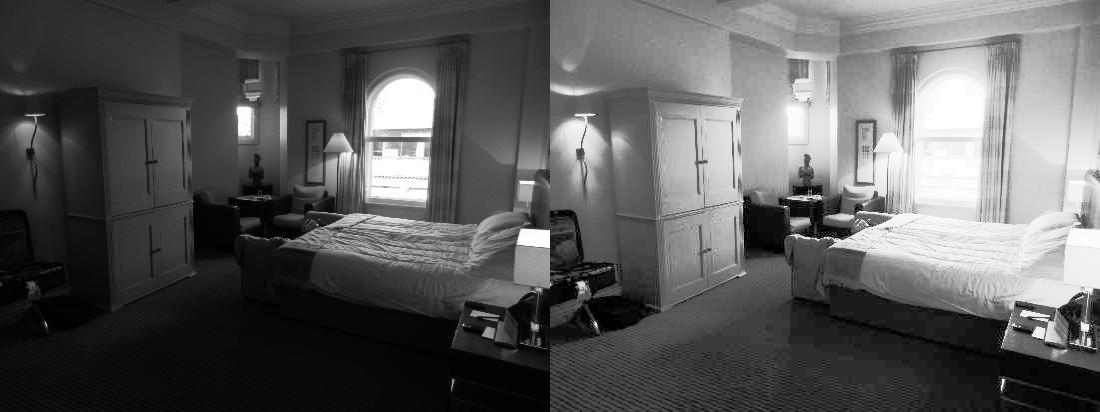

In [ ]:
# Compare the grayscale images before and after the equalisation
for sample_file in sample_files:
    if IN_COLAB:
        print('#'*40,sample_file,'(before and after)','#'*40)
        cv2_imshow(np.hstack((cv.imread(sample_file,0),cv.imread('he_gray_'+sample_file, 0))))
    else:
        title = '#'*40+' '+sample_file+' (before and after) '+'#'*40
        plt.figure(figsize = (15,15))
        plt.title(title)
        plt.imshow(np.hstack((cv.imread(sample_file,0),cv.imread('he_gray_'+sample_file,0))).astype('uint8'),cmap = 'gray')


# 2. Pros & Cons of histogram equalisation + Causes of unsastifactory contrast enhancement

Pros:
* It is straightforward in implementation but yields reasonably good contrast enhancement. 
    * E.g. We are able to see the details of the dark regions in `sample05.jpeg` and  `sample06.jpg`  clearly after the histogram equalisation, as shown in `he_sample05.jpeg` and `he_sample06.jpg`.
* It has relatively low computation cost compared to other adaptive histogram equalisations.

Cons:
* Since the histogram equlisation only considers global level contrast, 
    * For overexposed images, high percentage of high intensity values result in the contrast of background noise being increased. E.g. There are salt-and-pepper kind of noise spotted on the building walls and background of `he_sample01.jpg`
    * For underexposed images, high percentage of low intensity value results in meaningful details at light region becomes unobservable E.g. The edges of the ceiling light in `sample07.jpy` and the details outside the window in `sample08.jpg.
* As the histogram equalisation is performed on each colour channel separately, some images will have unnatural colours
    * E.g. Unnatural purple hue found in `he_sample04.jpeg` which is supposed to be a forest scene
* For images with very narrow range of intensity values, histogram equalisation will result zero or low occurrence at certain intensity value. This results in images having a patchy look due to abrupt change in intensity value.
    * E.g. This can be observed in `he_sample01.jpg` and `he_sample02.jpeg`



Some of the cons found on internet:
* Histogram equalization based image enhancement tool does not provide the brightness preservation and better contrast enhancement. This may cause loss in diagnostic information in case of medical images.
* In the consumer electronics field, the main challenge in image processing is to preserve the original brightness

# 3. Other methods that can overcome the disadvantages of histogram equalisation
1. To overcome the issue caused by taking global level contrast, we can use adaptive histogram equalisation which takes into consideration of local level contrast. 
2. To prevent images from having unnatural colouration, we can perform histogram equalisation on other colourspaces such as HSV, HSL or LAB instead of RGB. Then, we can adjust the lightness while maintaining the chromaticity of the images.
3. We can limit the amount of stretching done by the histogram equalisation by using partial histogram equalisation

* Contrast enhancement using brightness preserving bi-histogram equalization 1997
* Contrast enhancement using recursive mean-separate histogram equalization for scalable brightness preservation 2003
* Fast image/video contrast enhancement based on weighted thresholded histogram equalization 2007
* Range limited bi-histogram equalization for image contrast enhancement 2013

## 3.1 Contrast Limited Adaptive Histogram Equalisation (CLAHE)

Adaptive histogram equalisation is a method that performs histogram equalisation across multiple smaller regions of the image so local level contrast is accounted for.

In this section, we will first experiment with Contrast Limited Adaptive Histogram Equalisation (CLAHE) which is a variant of adaptive histogram equalisation. This variant helps to overcome the issue of ordinary adaptive histogram equalisation which will overstretch the pixel values and amplify noises at near homogeneous regions.

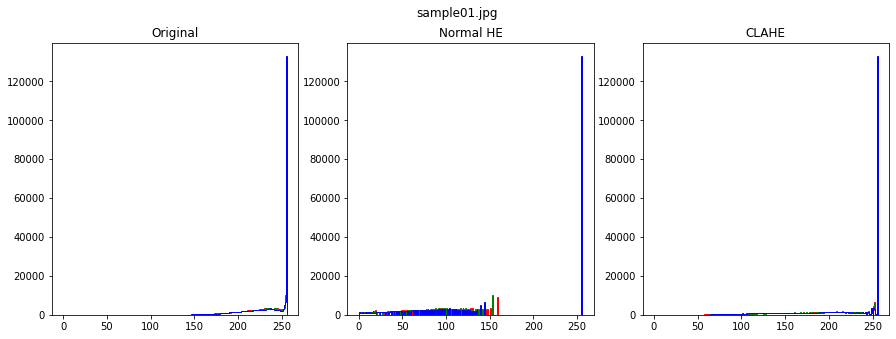

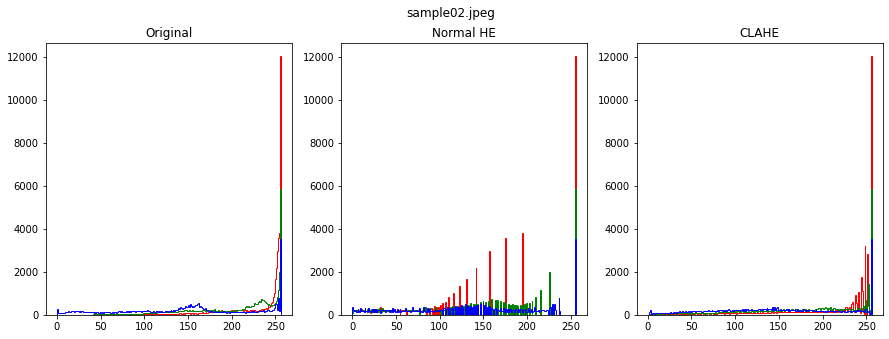

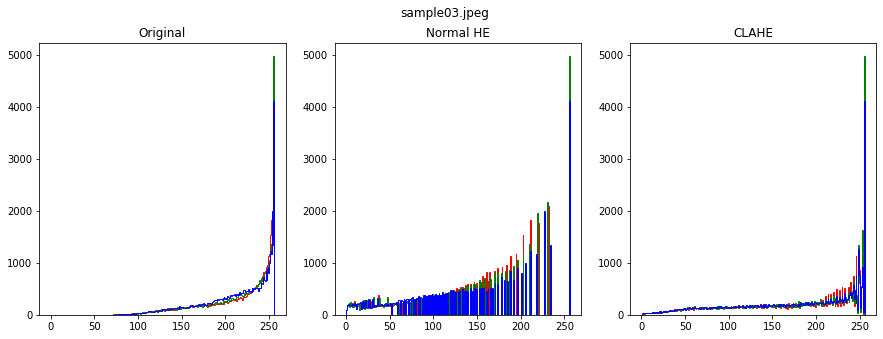

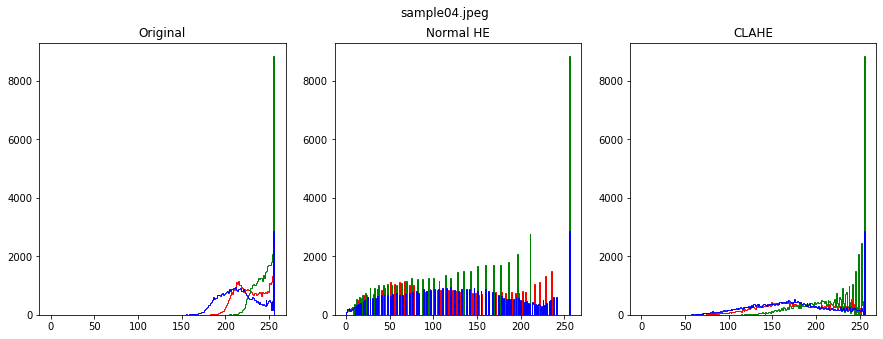

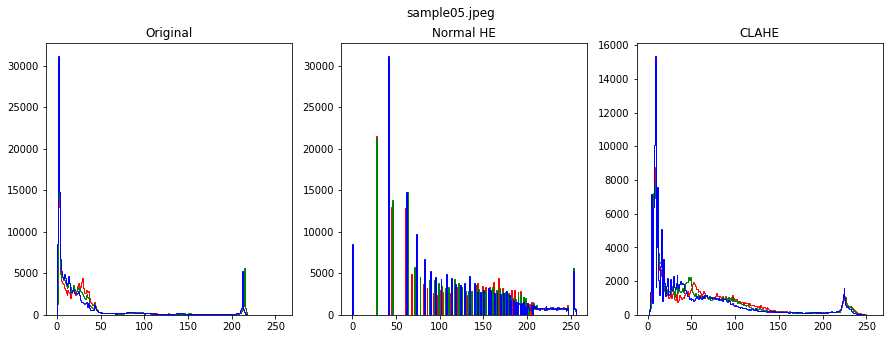

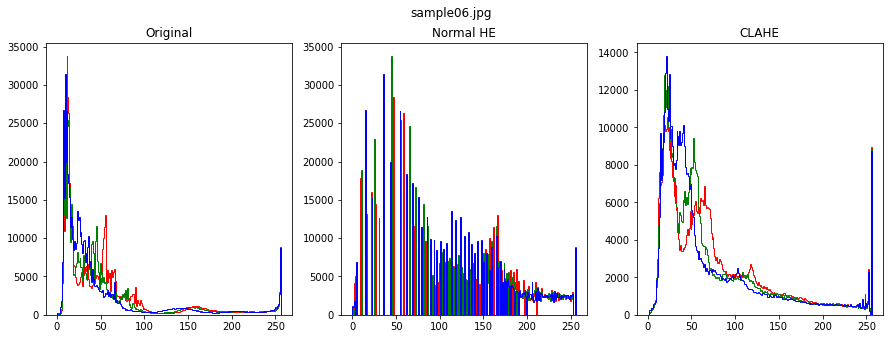

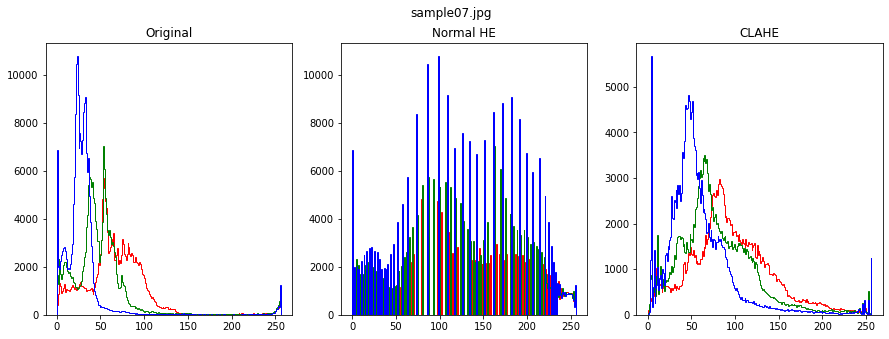

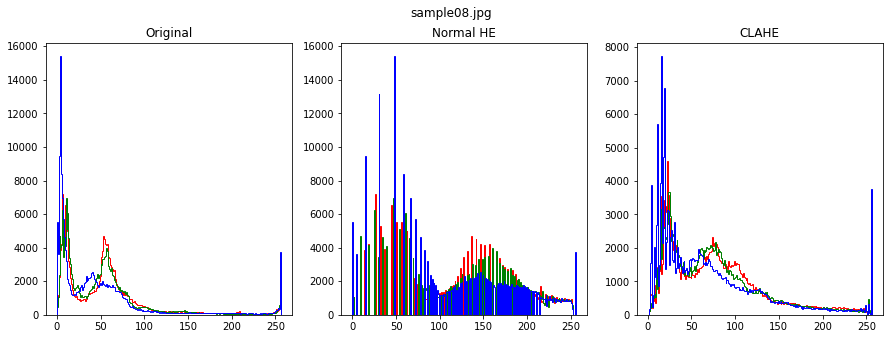

In [ ]:
# Save the images with a prefix 'clahe_' after applying CLAHE
for sample_file in sample_files:
    sample_img = cv.imread(sample_file)
    b,g,r = cv.split(sample_img)

    he_b = transform_pixel(b)[b]
    he_g = transform_pixel(g)[g]
    he_r = transform_pixel(r)[r]

    # Let tileGridSize to be 2% of the width and height 
    tileGridSize = (int(b.shape[0]*0.02),int(b.shape[1]*0.02))
    clipLimit = 3

    clahe = cv.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)

    clahe_b = clahe.apply(b)
    clahe_g = clahe.apply(g)
    clahe_r = clahe.apply(r)

    clahe_sample_img = cv.merge([clahe_b, clahe_g, clahe_r])
    
    cv.imwrite('clahe_'+sample_file, clahe_sample_img) # Save the new image to the folder

    # Plot their rgb histograms before and after the histogram equalisation
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
    ax1.hist(r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax1.hist(g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax1.hist(b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax1.set_title('Original')
    
    ax2.hist(he_r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax2.hist(he_g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax2.hist(he_b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax2.set_title('Normal HE')

    ax3.hist(clahe_r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax3.hist(clahe_g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax3.hist(clahe_b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax3.set_title('CLAHE')   

    fig.suptitle(sample_file)
    plt.savefig(f'{sample_file.split(".")[0]}_clahe_before_after.png')
    plt.show()

In [ ]:
# Compare the coloured images before and after CLAHE
for sample_file in sample_files:
    if IN_COLAB:
        print('#'*40,sample_file,'(Original, Normal HE, CLAHE)','#'*40)
        cv2_imshow(np.hstack((cv.imread(sample_file,1),cv.imread('he_'+sample_file, 1),cv.imread('clahe_'+sample_file,1))))
    else:
        title = '#'*40+' '+sample_file+' (Original, Normal HE, CLAHE) '+'#'*40
        plt.figure(figsize = (15,15))
        plt.title(title)
        plt.imshow(cv.cvtColor(np.hstack((cv.imread(sample_file,1),cv.imread('he_'+sample_file, 1),cv.imread('clahe_'+sample_file,1))).astype('uint8'), cv.COLOR_BGR2RGB))

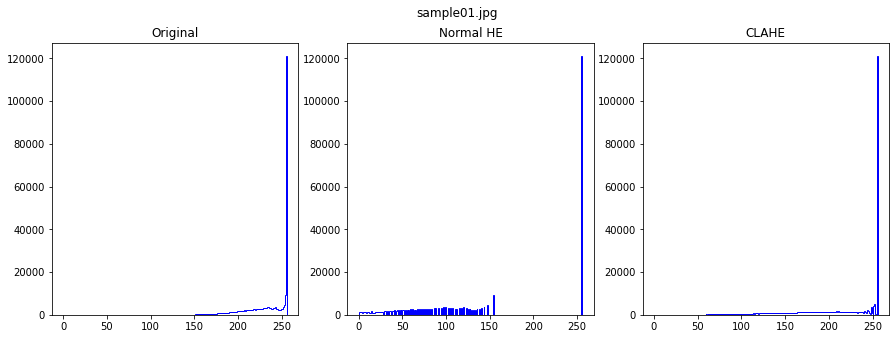

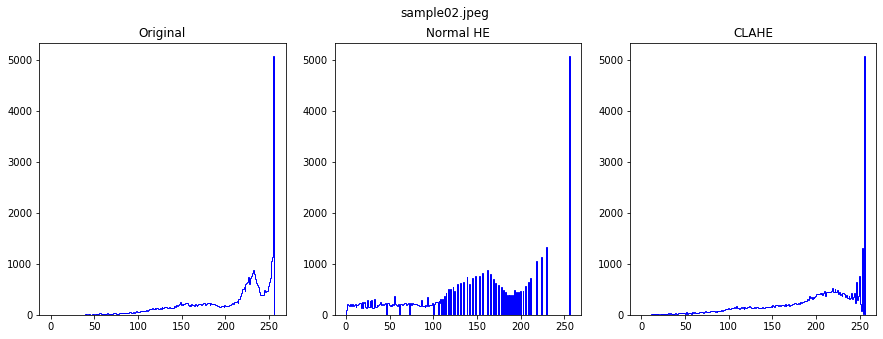

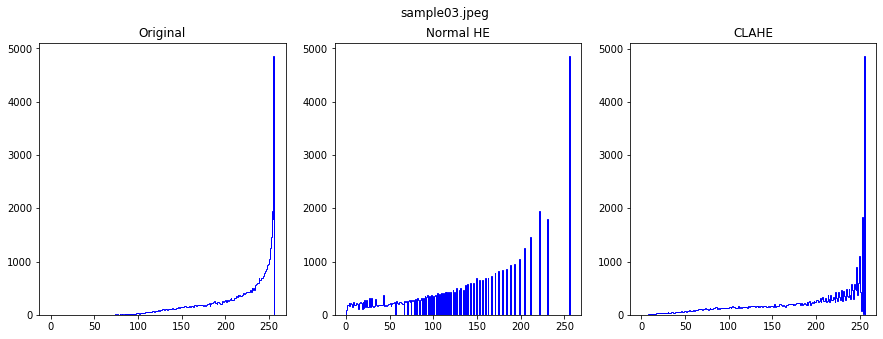

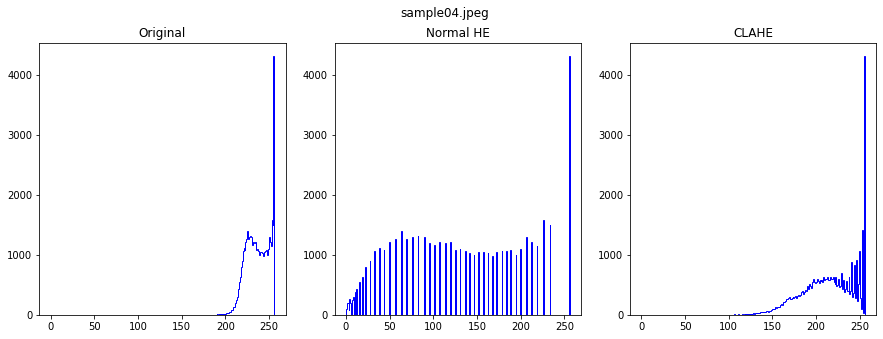

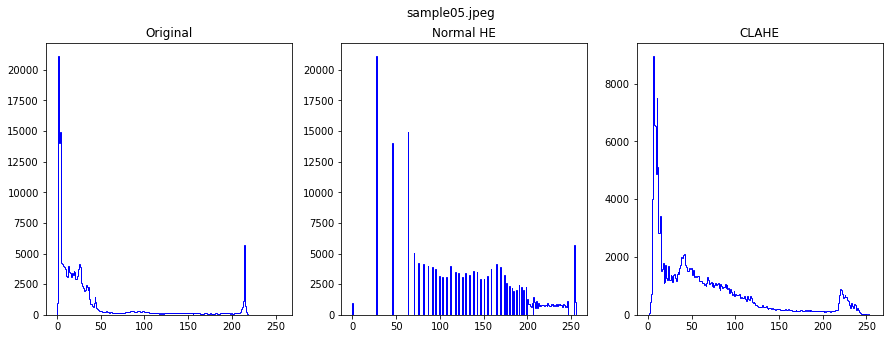

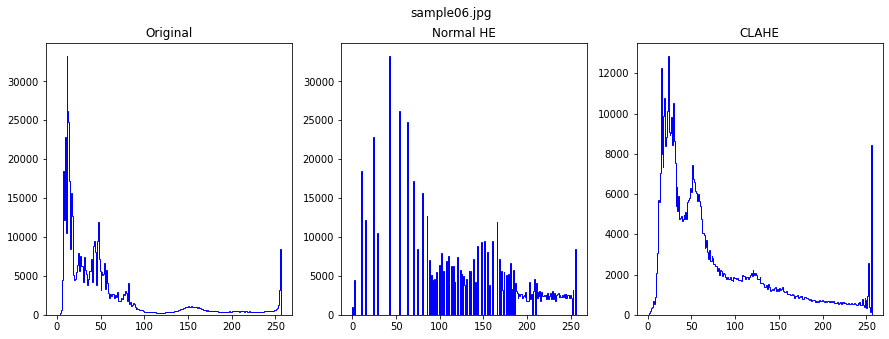

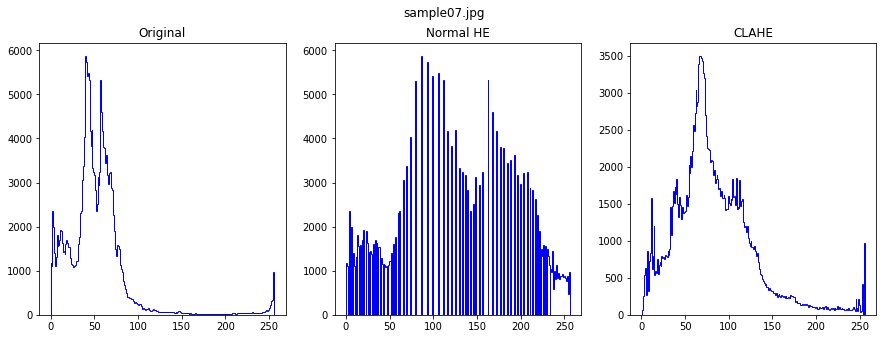

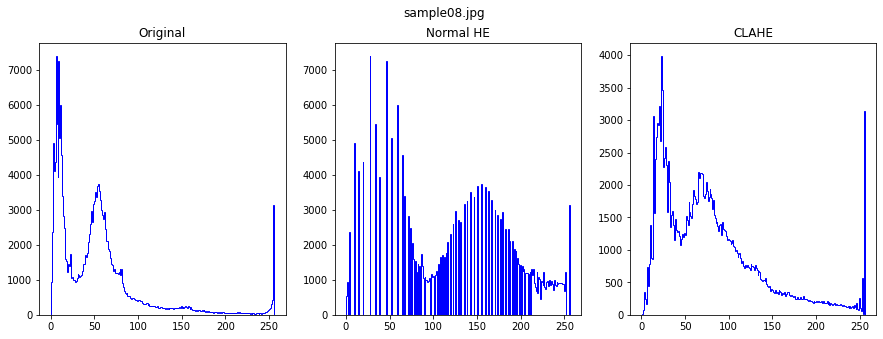

In [ ]:
# For grayscale images
# Save the images with a prefix 'clahe_gray_' after applying CLAHE on the grayscale images
for sample_file in sample_files:
    sample_img = cv.imread(sample_file,0)

    he_gray_sample_img = transform_pixel(sample_img)[sample_img]

    tileGridSize = (int(b.shape[0]*0.02),int(b.shape[1]*0.02))
    clipLimit = 3

    clahe = cv.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    clahe_gray_sample_img = clahe.apply(sample_img)

    cv.imwrite('clahe_gray_'+sample_file, clahe_gray_sample_img) # Save the new image to the folder

    # Plot their rgb histograms before and after the histogram equalisation
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
    ax1.hist(sample_img.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax1.set_title('Original')
    
    ax2.hist(he_gray_sample_img.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax2.set_title('Normal HE')

    ax3.hist(clahe_gray_sample_img.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax3.set_title('CLAHE')

    fig.suptitle(sample_file)
    plt.savefig(f'{sample_file.split(".")[0]}_clahe_gray_before_after.png')
    plt.show()

In [ ]:
# Compare the grayscale images before and after CLAHE
for sample_file in sample_files:
    if IN_COLAB:
        print('#'*40,sample_file,'(Original, Normal HE, CLAHE)','#'*40)
        cv2_imshow(np.hstack((cv.imread(sample_file,0),cv.imread('he_gray_'+sample_file, 0),cv.imread('clahe_gray_'+sample_file,0))))
    else:
        title = '#'*40+' '+sample_file+' (Original, Normal HE, CLAHE) '+'#'*40
        plt.figure(figsize = (15,15))
        plt.title(title)
        plt.imshow(np.hstack((cv.imread(sample_file,0),cv.imread('he_gray_'+sample_file,0), cv.imread('clahe_gray_'+sample_file,0))).astype('uint8'),cmap = 'gray')

## 3.2 CLAHE on CIELAB colourspace

As mentioned earlier, performing histogram equalisation on RGB channel can result in unnatural hue since the image chromaticity is modified. Hence we can perform CLAHE on CIELAB colour space, which is defined by 3 parameters(l\*, a\*, b\*). l\* represents the perceptual lightness while a\* and b\* represents red, green, blue, and yellow.

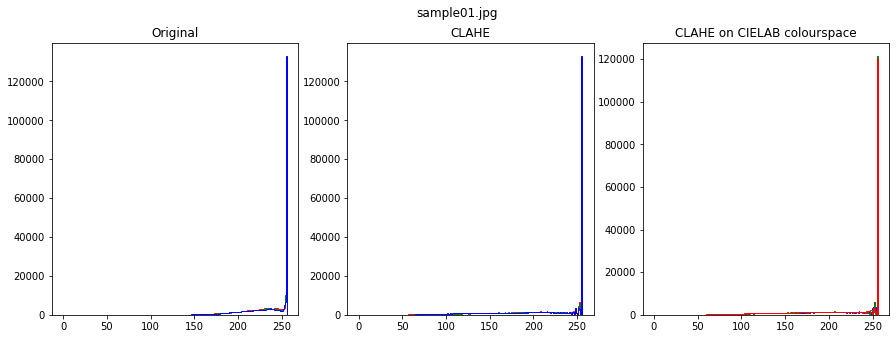

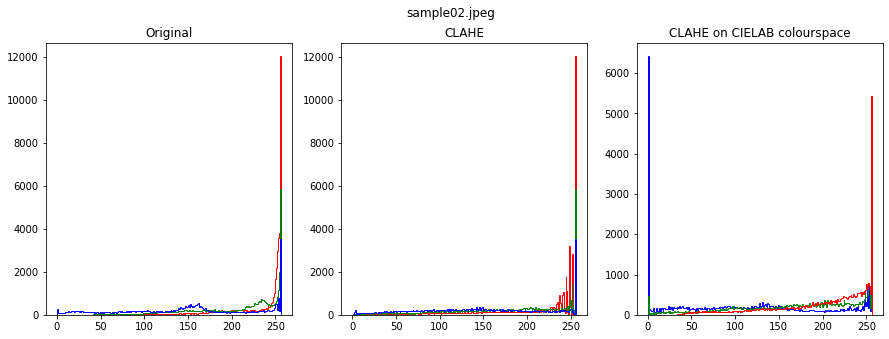

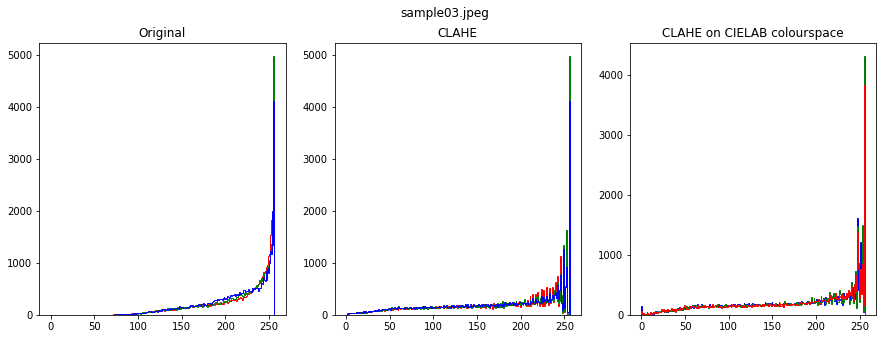

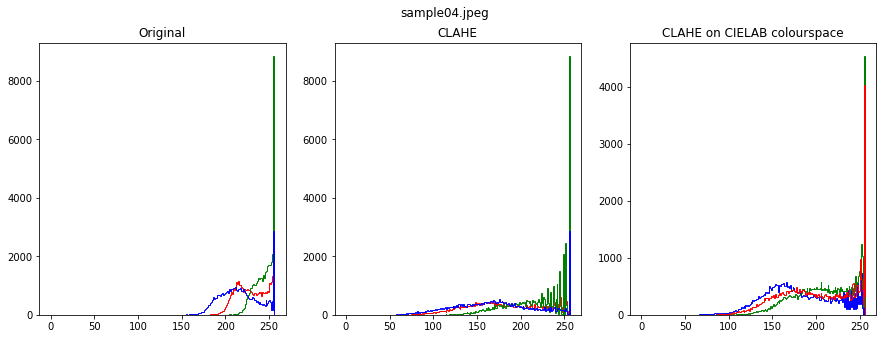

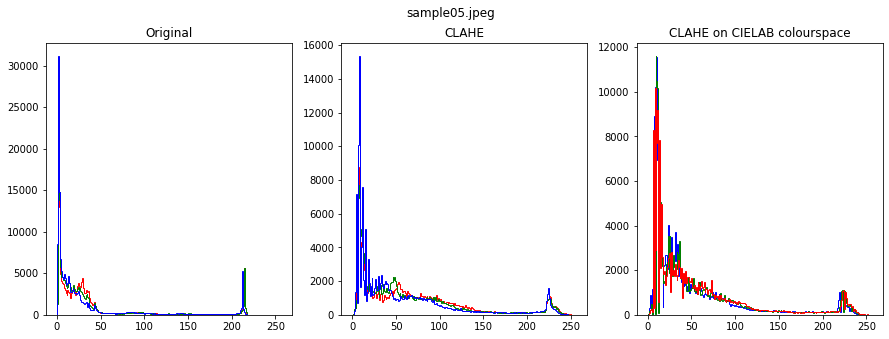

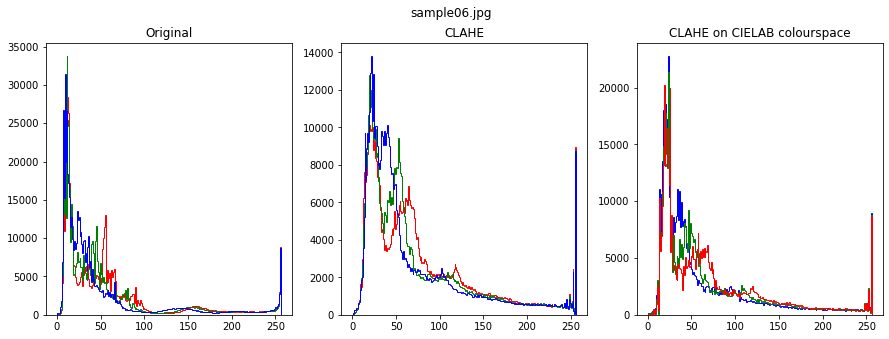

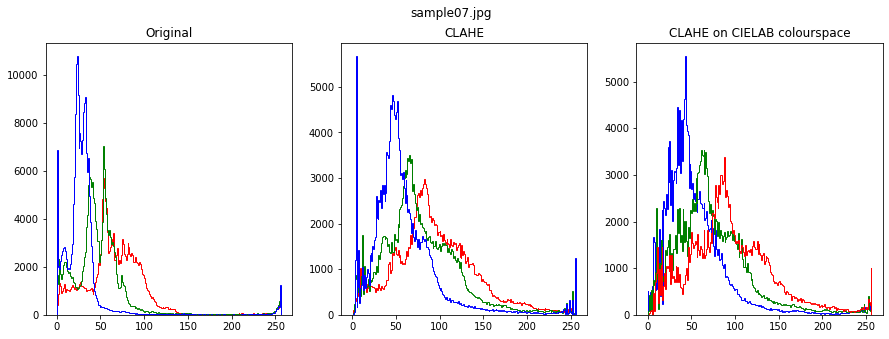

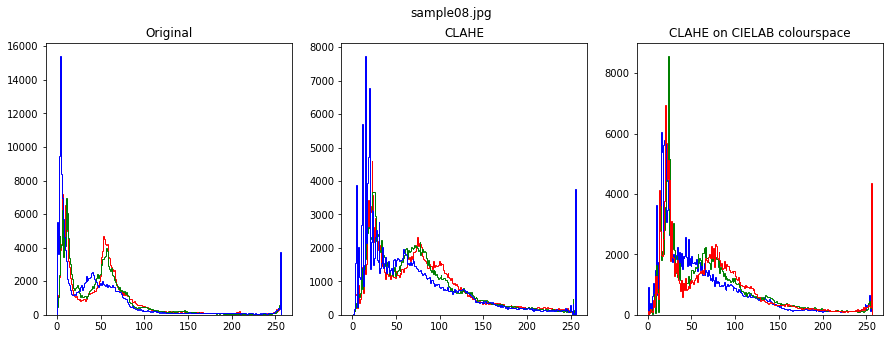

In [ ]:
# Save the images with a prefix 'clahe_lab_' after applying CLAHE on the LAB colourspace
for sample_file in sample_files:
    sample_img = cv.imread(sample_file)
    b,g,r = cv.split(sample_img)

    # Let tileGridSize to be 2% of the width and height 
    tileGridSize = (int(b.shape[0]*0.02),int(b.shape[1]*0.02))
    clipLimit = 3

    clahe = cv.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)

    clahe_b = clahe.apply(b)
    clahe_g = clahe.apply(g)
    clahe_r = clahe.apply(r)

    clahe_sample_img = cv.merge([clahe_b, clahe_g, clahe_r])

    L,A,B = cv.split(cv.cvtColor(sample_img, cv.COLOR_BGR2LAB))
    # We only perform CLAHE on the L channel, which is the perceptual lightness
    clahe_L = clahe.apply(L)
    clahe_lab_sample_img = cv.cvtColor(cv.merge([clahe_L,A,B]), cv.COLOR_LAB2BGR)

    clahe_lab_sample_img_B, clahe_lab_sample_img_G, clahe_lab_sample_img_R = cv.split(clahe_lab_sample_img)
    
    cv.imwrite('clahe_lab_'+sample_file, clahe_lab_sample_img) # Save the new image to the folder

    # Plot their rgb histograms before and after the histogram equalisation
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
    ax1.hist(r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax1.hist(g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax1.hist(b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax1.set_title('Original')
    
    ax2.hist(clahe_r.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax2.hist(clahe_g.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax2.hist(clahe_b.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax2.set_title('CLAHE')   

    ax3.hist(clahe_lab_sample_img_B.flat, bins = 256, range=(0,256), histtype = 'step', color='b')
    ax3.hist(clahe_lab_sample_img_G.flat, bins = 256, range=(0,256), histtype = 'step', color='g')
    ax3.hist(clahe_lab_sample_img_R.flat, bins = 256, range=(0,256), histtype = 'step', color='r')
    ax3.set_title('CLAHE on CIELAB colourspace')  

    fig.suptitle(sample_file)
    plt.savefig(f'{sample_file.split(".")[0]}_clahe_lab_before_after.png')
    plt.show()

In [ ]:
# Compare the coloured images before and after CLAHE
for sample_file in sample_files:
    if IN_COLAB:
        print('#'*40,sample_file,'(Original, CLAHE, CLAHE on LAB)','#'*40)
        cv2_imshow(np.hstack((cv.imread(sample_file,1),cv.imread('clahe_'+sample_file, 1),cv.imread('clahe_lab_'+sample_file,1))))
    else:
        title = '#'*40+' '+sample_file+' (Original, CLAHE, CLAHE on LAB) '+'#'*40
        plt.figure(figsize = (15,15))
        plt.title(title)
        plt.imshow(cv.cvtColor(np.hstack((cv.imread(sample_file,1),cv.imread('clahe_'+sample_file, 1),cv.imread('clahe_lab_'+sample_file,1))).astype('uint8'), cv.COLOR_BGR2RGB))

##3.3 Implementation of Adaptive Histogram Equalization (AHE)

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


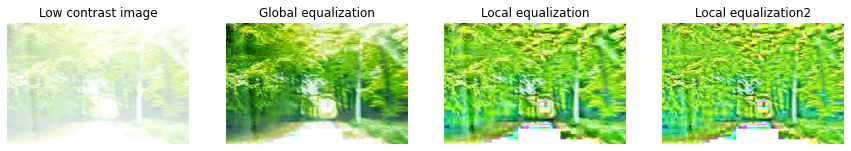

In [ ]:

# Original image
img = np.array(Image.open(sample_files[3]))

# Global equalize
img_global = exposure.equalize_hist(img)

# Local Equalization, disk shape kernel
# Better contrast with disk kernel but could be different
kernel = morp.ball(15)
kernel2 = morp.cube(15)
img_local = rank.equalize(img, selem=kernel)
img_local2 = rank.equalize(img, selem=kernel2)


fig, (ax_img, ax_global, ax_local,ax_local2) = plt.subplots(1, 4, figsize = (15,15))

ax_img.imshow(img, cmap=plt.cm.gray)
ax_img.set_title('Low contrast image')
ax_img.set_axis_off()

ax_global.imshow(img_global, cmap=plt.cm.gray)
ax_global.set_title('Global equalization')
ax_global.set_axis_off()

ax_local.imshow(img_local, cmap=plt.cm.gray)
ax_local.set_title('Local equalization')
ax_local.set_axis_off()

ax_local2.imshow(img_local2, cmap=plt.cm.gray)
ax_local2.set_title('Local equalization2')
ax_local2.set_axis_off()